In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm


##############################################
# 1) Original get_grads, unchanged
##############################################
def get_grads(model: nn.Module, dataloader: DataLoader):
    oneitem = next(iter(dataloader))
    if isinstance(oneitem, dict):
        # huggingface style dictionary dataset
        model.train()
        model.zero_grad()
        device = next(model.parameters()).device
        crit = nn.CrossEntropyLoss()
        for batch in tqdm(dataloader, desc="Getting grads"):
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(
                inputs["input_ids"], attention_mask=inputs["attention_mask"]
            )
            loss = crit(outputs.logits, inputs["label"])
            loss.backward()
        with torch.no_grad():
            mean_grads = {
                name: p.grad.div_(len(dataloader))
                for name, p in model.named_parameters() if p.grad is not None
            }
        model.zero_grad()
        model.eval()
        return mean_grads
    else:
        # standard (inputs, targets) style, e.g. CIFAR10
        model.train()
        model.zero_grad()
        device = next(model.parameters()).device
        crit = nn.CrossEntropyLoss()
        for batch in tqdm(dataloader, desc="Getting grads"):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = crit(outputs, targets)
            loss.backward()
        with torch.no_grad():
            mean_grads = {
                name: p.grad.div_(len(dataloader))
                for name, p in model.named_parameters() if p.grad is not None
            }
        model.zero_grad()
        model.eval()
        return mean_grads


##############################################
# 2) Helper to measure average cross-entropy loss
##############################################
def measure_loss(model: nn.Module, dataloader: DataLoader, device="cpu"):
    model.eval()
    crit = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = crit(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    return total_loss / total_samples


##############################################
# 3a) Helper function to compute uvgrads
##############################################
def get_uvgrad(model: nn.Module, grads: dict, layer_key: str):
    """
    Returns:
    -------
      U, S, Vt, uvgrads_single

    Where:
      * U, S, Vt are from torch.linalg.svd on the (possibly flattened) layer.
      * uvgrads_single[i] = cost if removing only the i-th singular vector.
    """
    # Make sure the layer_key is in grads
    if layer_key not in grads:
        raise ValueError(f"Layer '{layer_key}' not found in grads dict.")

    # Extract the parameter
    param_dict = dict(model.named_parameters())
    if layer_key not in param_dict:
        raise ValueError(f"Layer '{layer_key}' not found in model parameters.")
    param = param_dict[layer_key]

    # Clone original weights (just for safety; not strictly needed here)
    W_orig = param.detach().clone()
    original_shape = W_orig.shape

    # Flatten if convolutional
    if W_orig.dim() >= 3:
        W_flat = W_orig.view(original_shape[0], -1)
        G_flat = grads[layer_key].view(original_shape[0], -1)
    else:
        W_flat = W_orig
        G_flat = grads[layer_key]

    # Perform SVD on the flattened weight
    U, S, Vt = torch.linalg.svd(W_flat, full_matrices=False)

    # Compute uvgrads_single
    # This is effectively the cost of "removing" each singular vector alone
    uvgrads_single = torch.einsum("k, mk, kn, mn -> k", S, U, Vt, G_flat)

    return U, S, Vt, uvgrads_single


##############################################
# 3b) Modified demo, but uses get_uvgrad
##############################################
def demo_deleting_weights_from_rank_k_upwards_realtime(
    model: nn.Module,
    dataloader: DataLoader,
    layer_key: str,
    grads,
    ratio=1.0,
    device="cpu"
):
    """
    Perform rank-truncation experiments on the specified layer (e.g., 'fc.weight'),
    computing the predicted vs. actual increase in loss when removing singular vectors
    from rank=k upwards. Returns the figure, the rank list, predicted diffs, and
    actual losses.

    If the layer is convolutional, we reshape from (cout, cin, k, k, ...)
    into (cout, cin*k*k*...) for the SVD, then reshape back after partial reconstruction.
    """

    # A) Ensure model is on the right device and measure baseline
    model.to(device)
    baseline_loss = measure_loss(model, dataloader, device=device)
    print(f"Baseline loss (full rank): {baseline_loss:.5f}")

    # B) Get U, S, Vt, uvgrads_single from our new helper
    U, S, Vt, uvgrads_single = get_uvgrad(model, grads, layer_key)

    # C) We'll need param references to apply partial reconstructions
    param_dict = dict(model.named_parameters())
    param = param_dict[layer_key]
    W_orig = param.detach().clone()
    original_shape = W_orig.shape

    # Flatten if needed, so partial_reconstruction is straightforward
    if param.dim() >= 3:
        W_orig_flat = W_orig.view(original_shape[0], -1)
    else:
        W_orig_flat = W_orig

    r = len(S)

    # uvgrads_cum: sum of uvgrads from i..r-1
    # We can do: uvgrads_cum[i] = sum(uvgrads_single[i..r-1])
    # A neat trick is cumsum from the left or the right
    uvgrads_cumulative_sum = uvgrads_single.flip(dims=[0]).cumsum(dim=0).flip(dims=[0])
    # uvgrads_cumulative_sum[i] = uvgrads_single[i] + ... + uvgrads_single[r-1]

    # Partial reconstruction function
    def partial_reconstruction(rank_i: int) -> torch.Tensor:
        """ Keep top 'rank_i' singular vectors. """
        if rank_i == 0:
            return torch.zeros_like(W_orig_flat)
        Ui = U[:, :rank_i]
        Si = torch.diag(S[:rank_i])
        Vti = Vt[:rank_i, :]
        return Ui @ Si @ Vti

    # Lists to store results
    predicted_diffs = []
    actual_losses = []
    ranks = list(range(int(r * ratio)))

    for i in ranks:
        # 1) Partial reconstruction with top 'i' singular vectors
        Wi_flat = partial_reconstruction(i)

        # 2) Copy back
        if param.dim() >= 3:
            param.data.copy_(Wi_flat.view(*original_shape))
        else:
            param.data.copy_(Wi_flat)

        # 3) Measure actual loss
        loss_i = measure_loss(model, dataloader, device=device)
        actual_losses.append(loss_i)

        # 4) Predicted difference (removing i..r-1)
        #    uvgrads_cumulative_sum[i] is sum(uvgrads_single[i..r-1]),
        #    so predicted diff from baseline = baseline_loss + uvgrads_cumulative_sum[i]
        predicted_diff_i = (baseline_loss + uvgrads_cumulative_sum[i]).item()
        predicted_diffs.append(predicted_diff_i)

    # Restore original param
    param.data.copy_(W_orig)
    print("Done! Restored original full-rank weight to the model.")

    # Plot
    fig = plt.figure()
    plt.plot(ranks, predicted_diffs, label="Predicted Loss Diff")
    plt.plot(ranks, actual_losses, label="Actual Loss")
    plt.xlabel("Kept Rank i (0..r)")
    plt.ylabel("Loss / Predicted Loss")
    plt.title("Deleting from rank=i Upwards:\nComparing Predicted vs. Actual Loss")
    plt.legend()
    plt.show()

    return fig, ranks, predicted_diffs, actual_losses



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.resnet18(pretrained=True).to(device)

# Or for a convolutional layer, something like:
# layer_key = "layer4.2.conv2.weight"

transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
])
dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
subset_dataset = Subset(dataset, torch.randperm(len(dataset))[:100])
small_loader = DataLoader(subset_dataset, batch_size=16, shuffle=False)
grads = get_grads(model, small_loader)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Getting grads: 100%|██████████| 7/7 [00:00<00:00, 11.08it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
fig, ranks, predicted, actual = demo_deleting_weights_from_rank_k_upwards_realtime(
    model, small_loader, "fc.weight", grads, device=device, ratio=0.3
)

Baseline loss (full rank): 10.14694


KeyboardInterrupt: 

In [79]:
fig, ranks, predicted, actual = demo_deleting_weights_from_rank_k_upwards_realtime(
    model, small_loader, "layer4.0.conv1.weight", grads, device=device
)

Baseline loss (full rank): 9.23350


KeyboardInterrupt: 

Baseline loss (full rank): 9.97111
Done! Restored original full-rank weight to the model.


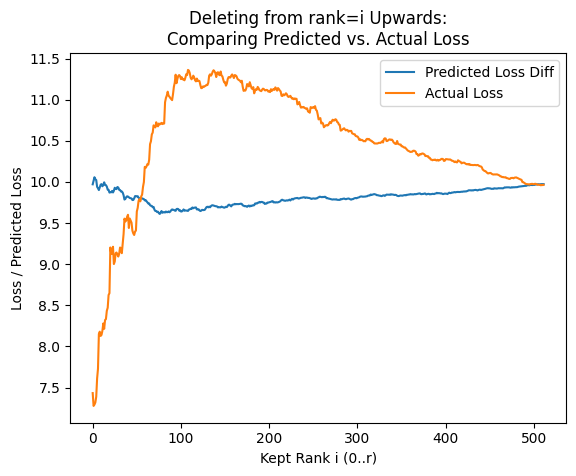

In [90]:
fig, ranks, predicted, actual = demo_deleting_weights_from_rank_k_upwards_realtime(
    model, small_loader, "layer4.0.conv2.weight", grads, device=device
)

Baseline loss (full rank): 9.97066
Done! Restored original full-rank weight to the model.


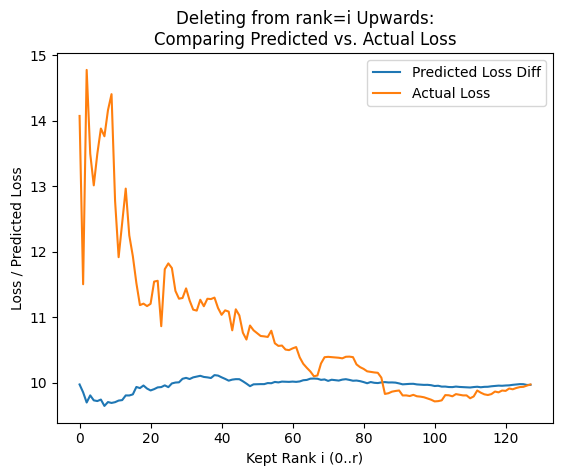

In [88]:
fig, ranks, predicted, actual = demo_deleting_weights_from_rank_k_upwards_realtime(
    model, small_loader, "layer2.0.conv2.weight", grads, device=device
)

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
##############################################
# 1) Original get_grads, unchanged
##############################################
def get_hvp(model: nn.Module, dataloader, v):
    """
    Compute the (average) Hessian-vector product for the given model and dataloader.

    Args:
        model (nn.Module): The model whose parameters we want the Hessian for.
        dataloader (DataLoader): DataLoader for the dataset over which we compute the HVP.
        v (Dict[str, torch.Tensor]): Dictionary of direction vectors, keyed by parameter name,
                                     matching the shape of each corresponding parameter.

    Returns:
        hvp (Dict[str, torch.Tensor]): Dictionary of Hessian-vector products, keyed by parameter name.
    """
    # H.v = d(d(f)) * v = d(d(f) * v)
    # Make sure the model is in training mode (if that affects your forward pass)
    model.train()
    device = next(model.parameters()).device
    crit = nn.CrossEntropyLoss()

    # We will accumulate the final HVP in a dictionary, each param -> zero initially
    hvp = {name: torch.zeros_like(param, device=device)
           for name, param in model.named_parameters() if param.requires_grad}

    # We'll loop over the entire dataloader, accumulating the HVP
    num_batches = 0
    for batch in tqdm(dataloader, desc="Computing Hessian-Vector Product"):
        # === 1) Prepare inputs ===
        if isinstance(batch, dict):
            # huggingface style dictionary dataset
            inputs = {k: v_.to(device) for k, v_ in batch.items()}
            outputs = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
            loss = crit(outputs.logits, inputs["label"])
        else:
            # standard (inputs, targets) style
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = crit(outputs, targets)

        # === 2) Compute first-order gradients with create_graph=True ===
        # This does not accumulate into .grad yet; it returns a tuple of gradients.
        grads = torch.autograd.grad(loss,
                                    [p for p in model.parameters() if p.requires_grad],
                                    create_graph=True)

        # === 3) Compute the dot product with vector v and backprop to get Hessian-vector product ===
        # We'll sum up g_i * v_i for all parameters, then call backward on that scalar.
        dot = 0
        idx = 0
        named_params = [p for p in model.named_parameters() if p[1].requires_grad]
        for (name, param), g in zip(named_params, grads):
            # v[name] should have the same shape as param
            dot += torch.sum(g * v[name])
            idx += 1

        # Before calling backward, zero out existing .grad to accumulate *only* for this HVP pass
        model.zero_grad()
        dot.backward()  # This populates param.grad with Hessian-vector products

        # === 4) Accumulate the result into `hvp` dictionary, then zero_grad for next iteration ===
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                hvp[name] += param.grad.detach().clone()

        model.zero_grad()
        num_batches += 1

    # === 5) Average if desired ===
    for name in hvp:
        hvp[name] /= num_batches

    return hvp

##############################################
# 2) Helper to measure average cross-entropy loss
##############################################
def measure_loss(model: nn.Module, dataloader: DataLoader, device="cpu"):
    model.eval()
    crit = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = crit(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    return total_loss / total_samples


##############################################
# 3) Modified demo, accepting 'layer_key'
##############################################
def demo_deleting_weights_from_rank_k_upwards_realtime2(
    model: nn.Module,
    dataloader: DataLoader,
    layer_key: str,
    device="cpu"
):
    """
    Perform rank-truncation experiments on the specified layer (e.g., 'fc.weight'),
    computing the predicted vs. actual increase in loss when removing singular vectors
    from rank=k upwards. Returns the figure, the rank list, predicted diffs, and
    actual losses.

    If the layer is convolutional, we reshape from (cout, cin, k, k, ...)
    into (cout, cin*k*k*...) for the SVD, then reshape back after partial reconstruction.
    """

    # Make sure model is on the right device
    model.to(device)

    # A) Get baseline full-model loss
    baseline_loss = measure_loss(model, dataloader, device=device)
    print(f"Baseline loss (full rank): {baseline_loss:.5f}")

    uvgrads1 = get_uvgrad(model, get_grads(model, dataloader), layer_key)[3]
    # C) Extract the parameter we want to modify
    param_dict = dict(model.named_parameters())
    if layer_key not in param_dict:
        raise ValueError(f"Layer '{layer_key}' not found in model parameters.")
    param = param_dict[layer_key]

    # Make a clone of the original weights so we can restore later
    W_orig = param.detach().clone()
    original_shape = W_orig.shape

    # Flatten if convolutional (i.e., param.dim() >= 3)
    if param.dim() >= 3:
        # For example, [cout, cin, k, k] -> [cout, cin*k*k]
        W_orig_flat = W_orig.view(original_shape[0], -1)
        #G_flat = grads[layer_key].view(original_shape[0], -1)
    else:
        # It's already [out_features, in_features]
        W_orig_flat = W_orig
        #G_flat = grads[layer_key]

    # D) SVD on the flattened weight
    #    W_orig_flat: shape (C_out, C_in*k*k...) or (out_dim, in_dim)
    U, S, Vt = torch.linalg.svd(W_orig_flat, full_matrices=False)
    def partial_reconstruction(rank_i: int) -> torch.Tensor:
        """ Keep top 'rank_i' singular vectors. """
        if rank_i == 0:
            return torch.zeros_like(W_orig_flat)
        Ui = U[:, :rank_i]
        Si = torch.diag(S[:rank_i])
        Vti = Vt[:rank_i, :]
        return Ui @ Si @ Vti
    quantiles = min(len(S), 100)
    partial_quantiles = [partial_reconstruction(round(i * len(S) / quantiles)) for i in range(quantiles)]
    r = len(S)


    hvps = []
    for i in range(len(partial_quantiles)):
      vs = {name: torch.zeros_like(param, device=device) for name, param in param_dict.items()}
      vs[layer_key] = partial_quantiles[i].reshape(original_shape)
      _hvps = get_hvp(model, dataloader, vs)
      hvps.append(_hvps[layer_key].reshape(original_shape[0], -1))

    # E) uvgrads: cost if removing each singular vector alone
    #    (As in your code, uvgrads_single[i] is the cost for the i-th vector.)
    uvgrads_single = []
    idxs = list(range(len(S)))
    # partition idxs into quantiles
    idxs_quantiles = [idxs[round(i * len(S) / quantiles)] for i in range(quantiles)]
    from_to = list(zip(idxs_quantiles[:-1], idxs_quantiles[1:])) + [(idxs_quantiles[-1], len(S))]

    uvgrads = torch.zeros(
      S.shape[0],
      device=W_orig_flat.device,       # Put the tensor on the same device
      dtype=W_orig_flat.dtype         # Match the same dtype, if desired
    )

    for i in range(len(from_to)):
      f, t = from_to[i][0], from_to[i][1]
      uv_grads_loc = torch.einsum("k, mk, kn, mn -> k", S[f:t], U[:, f:t], Vt[f:t, :], hvps[i])
      print(uv_grads_loc.shape, uvgrads[f:t].shape, uvgrads.shape)
      uvgrads[f:t] = uv_grads_loc


    # Summation across i..r-1
    uvgrads_cum = uvgrads.sum() - uvgrads.cumsum(dim=0)

    uvgrads1_cum =  uvgrads1.sum() - uvgrads1.cumsum(dim=0)

    # G) For each rank i, reconstruct partial W, measure actual loss,
    #    compare to predicted difference = sum of uvgrads_single[i..r-1]
    predicted_diffs = []
    actual_losses = []
    ranks = list(range(r))

    for i in ranks:
        # 1) Partial reconstruction with top 'i' vectors
        Wi_flat = partial_reconstruction(i)

        # 2) Copy back into param (reshape if needed)
        if param.dim() >= 3:
            param.data.copy_(Wi_flat.view(*original_shape))
        else:
            param.data.copy_(Wi_flat)

        # 3) Measure actual loss with this truncated layer
        loss_i = measure_loss(model, dataloader, device=device)
        actual_losses.append(loss_i)

        # 4) Predicted difference from baseline_loss:
        #    sum( uvgrads_single[j] for j in [i..r-1] ) => -uvgrads_cum[i] + baseline_loss
        predicted_diff_i = (-uvgrads_cum[i] + uvgrads1_cum[i]/2 + baseline_loss).item()
        predicted_diffs.append(predicted_diff_i)

        # (Optional) If you want to see them in real time:
        # clear_output(wait=True)
        #print(f"Rank kept = {i:3d}, Actual Loss = {loss_i:.5f}, Predicted = {predicted_diff_i:.5f}")

    # H) Restore original parameter
    param.data.copy_(W_orig)
    print("Done! Restored original full-rank weight to the model.")

    # I) Generate plot comparing Actual vs. Predicted
    fig = plt.figure()
    plt.plot(ranks, predicted_diffs, label="Predicted Loss Diff")
    plt.plot(ranks, actual_losses, label="Actual Loss")
    plt.xlabel("Kept Rank i (0..r)")
    plt.ylabel("Loss / Predicted Loss")
    plt.title("Deleting from rank=i Upwards:\nComparing Predicted vs. Actual Loss")
    plt.legend()
    plt.show()

    return fig, ranks, predicted_diffs, actual_losses

Baseline loss (full rank): 10.17801


Computing Hessian-Vector Product: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]


torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([6]) torch.Size([6]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([6]) torch.Size([6]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])
torch.Size([5]) torch.Size([5]) torch.Size([512])


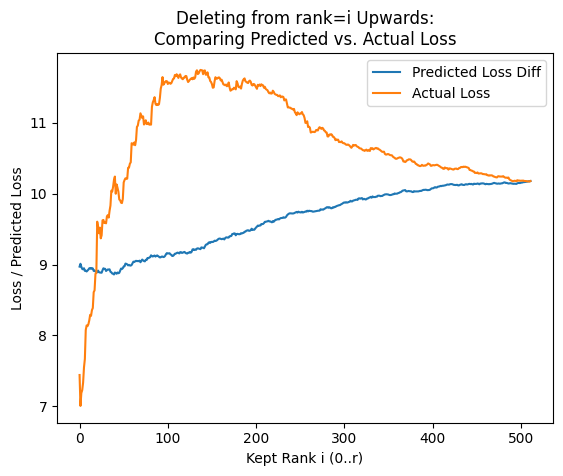

In [12]:

fig, ranks, predicted, actual = demo_deleting_weights_from_rank_k_upwards_realtime2(
    model, small_loader, "layer4.0.conv2.weight", device=device
)